In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import (roc_auc_score, accuracy_score, precision_score, 
                             recall_score, f1_score, confusion_matrix, roc_curve)
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from scipy.stats import uniform, randint
from sklearn.ensemble import VotingClassifier


import xgboost as xgb
import lightgbm as lgb
from sklearn.neural_network import MLPClassifier

%matplotlib inline

In [87]:
data_dir = "../data/processed/"

X_train = np.load(f"{data_dir}X_train.npy")
X_test = np.load(f"{data_dir}X_test.npy")
y_train = np.load(f"{data_dir}y_train.npy")
y_test = np.load(f"{data_dir}y_test.npy")

with open(f"{data_dir}feature_names.txt", 'r') as f:
    feature_names = [line.strip() for line in f.readlines()]

print(f"Dados de treino: {X_train.shape}")
print(f"Dados de teste: {X_test.shape}")
print(f"  Treino - Conversores: {(y_train == 1).sum()} ({(y_train == 1).sum()/len(y_train)*100:.1f}%)")
print(f"  Teste - Conversores: {(y_test == 1).sum()} ({(y_test == 1).sum()/len(y_test)*100:.1f}%)")

Dados de treino: (472, 27)
Dados de teste: (119, 27)
  Treino - Conversores: 153 (32.4%)
  Teste - Conversores: 39 (32.8%)



Vou tentar fazer a seleção de caracteristicas com dois métodos de seleção


In [88]:
k_values = [10, 15, 20, 'all']

cv_strategy = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)


selector_anova = SelectKBest(score_func=f_classif, k='all')
selector_anova.fit(X_train, y_train)

selector_mi = SelectKBest(score_func=mutual_info_classif, k='all')
selector_mi.fit(X_train, y_train)

feature_scores = pd.DataFrame({
    'Feature': feature_names,
    'ANOVA_F': selector_anova.scores_,
    'Mutual_Info': selector_mi.scores_
})

feature_scores = feature_scores.sort_values('ANOVA_F', ascending=False)
print("features por ANOVA F-value:" , feature_scores.head(15).to_string(index=False))

features por ANOVA F-value:               Feature    ANOVA_F  Mutual_Info
               adas13 196.162909     0.174075
                  faq 163.016085     0.133703
               adas11 150.424720     0.147681
      ravlt_immediate 127.309576     0.138713
ravlt_perc_forgetting  94.014179     0.100072
                cdrsb  92.350473     0.067915
                  fdg  74.178577     0.073181
       ravlt_learning  71.980294     0.096581
          hippocampus  58.159743     0.093294
           entorhinal  56.682604     0.041122
                 mmse  51.799831     0.072292
             fusiform  36.705440     0.032873
              midtemp  34.546749     0.043716
                apoe4  32.930046     0.017742
                 moca  32.163955     0.115466


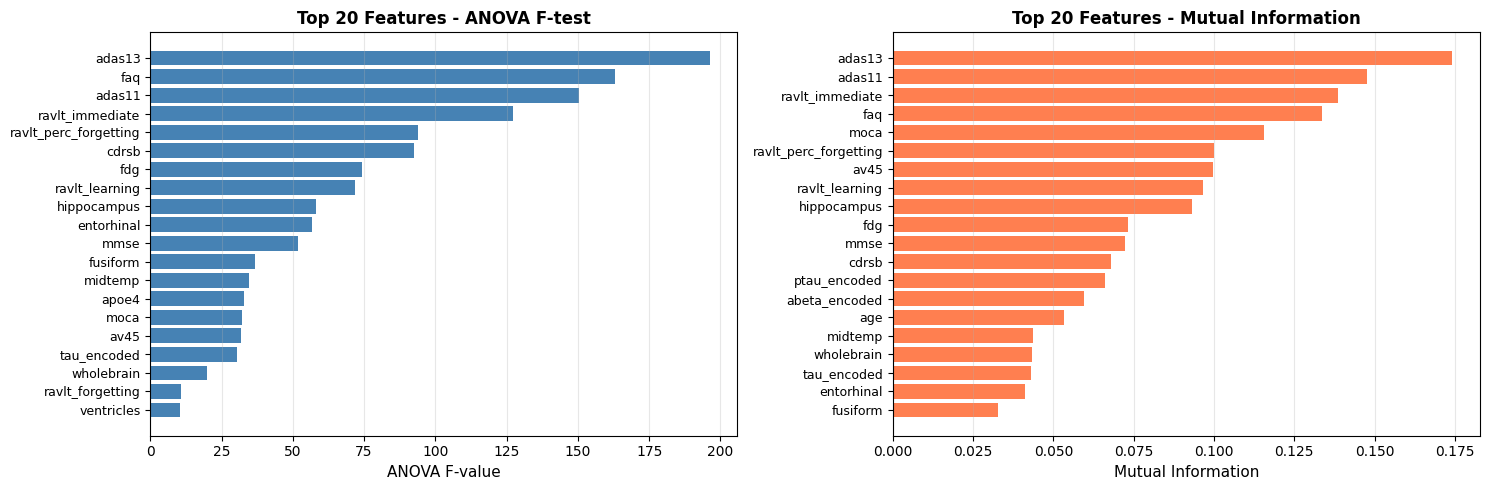

In [89]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

top_20_anova = feature_scores.head(20).sort_values('ANOVA_F')
axes[0].barh(range(20), top_20_anova['ANOVA_F'], color='steelblue')
axes[0].set_yticks(range(20))
axes[0].set_yticklabels(top_20_anova['Feature'], fontsize=9)
axes[0].set_xlabel('ANOVA F-value', fontsize=11)
axes[0].set_title('Top 20 Features - ANOVA F-test', fontweight='bold', fontsize=12)
axes[0].grid(axis='x', alpha=0.3)

top_20_mi = feature_scores.sort_values('Mutual_Info', ascending=False).head(20).sort_values('Mutual_Info')
axes[1].barh(range(20), top_20_mi['Mutual_Info'], color='coral')
axes[1].set_yticks(range(20))
axes[1].set_yticklabels(top_20_mi['Feature'], fontsize=9)
axes[1].set_xlabel('Mutual Information', fontsize=11)
axes[1].set_title('Top 20 Features - Mutual Information', fontweight='bold', fontsize=12)
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

Vou criar 3 conjuntos com todas as features pra preparar


In [90]:
feature_sets = {
    'all': list(range(X_train.shape[1])),
    'top15': feature_scores.head(15).index.tolist(),
    'top10': feature_scores.head(10).index.tolist()
}

print("Conjuntos de features criados:")
for name, indices in feature_sets.items():
    print(f"  {name}: {len(indices)} features")
    if name != 'all':
        print(f"    {[feature_names[i] for i in indices]}")

Conjuntos de features criados:
  all: 27 features
  top15: 15 features
    ['adas13', 'faq', 'adas11', 'ravlt_immediate', 'ravlt_perc_forgetting', 'cdrsb', 'fdg', 'ravlt_learning', 'hippocampus', 'entorhinal', 'mmse', 'fusiform', 'midtemp', 'apoe4', 'moca']
  top10: 10 features
    ['adas13', 'faq', 'adas11', 'ravlt_immediate', 'ravlt_perc_forgetting', 'cdrsb', 'fdg', 'ravlt_learning', 'hippocampus', 'entorhinal']


Aqui sao usados tres modelos nao testados no primeiro, XGBoost, LightGBM, MLP

In [91]:
models_config = {
    'XGBoost': {
        'estimator': xgb.XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False),
        'param_distributions': {
            'n_estimators': randint(100, 500),
            'max_depth': randint(3, 10),
            'learning_rate': uniform(0.01, 0.29),
            'subsample': uniform(0.7, 0.3),
            'colsample_bytree': uniform(0.7, 0.3),
            'min_child_weight': randint(1, 7),
            'gamma': uniform(0, 0.5)
        }
    },
    
    'LightGBM': {
        'estimator': lgb.LGBMClassifier(random_state=42, verbose=-1),
        'param_distributions': {
            'n_estimators': randint(100, 500),
            'max_depth': randint(3, 10),
            'learning_rate': uniform(0.01, 0.29),
            'num_leaves': randint(20, 100),
            'subsample': uniform(0.7, 0.3),
            'colsample_bytree': uniform(0.7, 0.3),
            'min_child_samples': randint(5, 30)
        }
    },
    
    'MLP': {
        'estimator': MLPClassifier(max_iter=500, random_state=42, early_stopping=True),
        'param_distributions': {
            'hidden_layer_sizes': [(50,), (100,), (150,), (50, 50), (100, 50)],
            'activation': ['relu', 'tanh'],
            'alpha': uniform(0.0001, 0.01),
            'learning_rate_init': uniform(0.001, 0.01)
        }
    }
}

print(f"Modelos configurados: {len(models_config)}")
for name, config in models_config.items():
    print(f" {name}")
    print(f" Hiperparâmetros: {list(config['param_distributions'].keys())}")

Modelos configurados: 3
 XGBoost
 Hiperparâmetros: ['n_estimators', 'max_depth', 'learning_rate', 'subsample', 'colsample_bytree', 'min_child_weight', 'gamma']
 LightGBM
 Hiperparâmetros: ['n_estimators', 'max_depth', 'learning_rate', 'num_leaves', 'subsample', 'colsample_bytree', 'min_child_samples']
 MLP
 Hiperparâmetros: ['hidden_layer_sizes', 'activation', 'alpha', 'learning_rate_init']


Agora vou treinar os modelos

In [92]:
results = []
trained_models = {}

for model_name, config in models_config.items():
    for feature_set_name, feature_indices in feature_sets.items():
                
        start_time = time.time()
        
        X_train_subset = X_train[:, feature_indices]
        X_test_subset = X_test[:, feature_indices]
        
        random_search = RandomizedSearchCV(
            estimator=config['estimator'],
            param_distributions=config['param_distributions'],
            n_iter=30,  
            cv=cv_strategy,
            scoring='roc_auc',
            n_jobs=-1,
            random_state=42,
            verbose=0
        )
        
        random_search.fit(X_train_subset, y_train)
        
        training_time = time.time() - start_time
        
        best_model = random_search.best_estimator_
        best_params = random_search.best_params_
        
        cv_roc_auc = random_search.best_score_
        cv_scores = cross_val_score(best_model, X_train_subset, y_train, 
                                     cv=cv_strategy, scoring='accuracy', n_jobs=-1)
        cv_accuracy = cv_scores.mean()
        
        y_pred_proba = best_model.predict_proba(X_test_subset)[:, 1]
        y_pred = best_model.predict(X_test_subset)
        
        test_roc_auc = roc_auc_score(y_test, y_pred_proba)
        test_accuracy = accuracy_score(y_test, y_pred)
        test_f1 = f1_score(y_test, y_pred)
        
        result = {
            'Model': model_name,
            'Features': feature_set_name,
            'N_Features': len(feature_indices),
            'CV_ROC_AUC': cv_roc_auc,
            'CV_Accuracy': cv_accuracy,
            'Test_ROC_AUC': test_roc_auc,
            'Test_Accuracy': test_accuracy,
            'Test_F1': test_f1,
            'Training_Time': training_time,
            'Best_Params': str(best_params)
        }
        results.append(result)
        
        model_key = f"{model_name}_{feature_set_name}"
        trained_models[model_key] = {
            'model': best_model,
            'feature_indices': feature_indices,
            'random_search': random_search
        }
        
        print(f"\nMelhores hiperparâmetros:")
        for param, value in best_params.items():
            print(f"  {param}: {value}")
        
        print(f"\nResultados:")
        print(f"  CV ROC-AUC:    {cv_roc_auc:.4f}")
        print(f"  Test ROC-AUC:  {test_roc_auc:.4f}")
        print(f"  Test Accuracy: {test_accuracy:.4f}")
        print(f"  Test F1:       {test_f1:.4f}")
        print(f"  Tempo:         {training_time:.1f}s")




Melhores hiperparâmetros:
  colsample_bytree: 0.7800343042825855
  gamma: 0.48830747791632645
  learning_rate: 0.12920073386228706
  max_depth: 9
  min_child_weight: 5
  n_estimators: 323
  subsample: 0.9724797657899961

Resultados:
  CV ROC-AUC:    0.9122
  Test ROC-AUC:  0.8628
  Test Accuracy: 0.7899
  Test F1:       0.6753
  Tempo:         14.4s

Melhores hiperparâmetros:
  colsample_bytree: 0.7816396748153905
  gamma: 0.32384506027068116
  learning_rate: 0.010150909328641588
  max_depth: 7
  min_child_weight: 1
  n_estimators: 358
  subsample: 0.7020856391593572

Resultados:
  CV ROC-AUC:    0.9138
  Test ROC-AUC:  0.8744
  Test Accuracy: 0.8151
  Test F1:       0.7179
  Tempo:         7.1s

Melhores hiperparâmetros:
  colsample_bytree: 0.7816396748153905
  gamma: 0.32384506027068116
  learning_rate: 0.010150909328641588
  max_depth: 7
  min_child_weight: 1
  n_estimators: 358
  subsample: 0.7020856391593572

Resultados:
  CV ROC-AUC:    0.9062
  Test ROC-AUC:  0.8740
  Test Accu

In [93]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Test_ROC_AUC', ascending=False).reset_index(drop=True)

print(results_df[['Model', 'Features', 'N_Features', 'CV_ROC_AUC', 
                   'Test_ROC_AUC', 'Test_Accuracy', 'Test_F1']].to_string(index=False))

print(f"\nMelhor modelo: {results_df['Model'].iloc[0]} com {results_df['Features'].iloc[0]}")
print(f"ROC-AUC Test: {results_df['Test_ROC_AUC'].iloc[0]:.4f}")

   Model Features  N_Features  CV_ROC_AUC  Test_ROC_AUC  Test_Accuracy  Test_F1
 XGBoost    top15          15    0.913790      0.874359       0.815126 0.717949
LightGBM    top10          10    0.912874      0.874359       0.798319 0.692308
 XGBoost    top10          10    0.906247      0.874038       0.823529 0.720000
LightGBM      all          27    0.918673      0.869231       0.815126 0.710526
LightGBM    top15          15    0.913138      0.866987       0.789916 0.675325
 XGBoost      all          27    0.912249      0.862821       0.789916 0.675325
     MLP      all          27    0.899758      0.860256       0.806723 0.701299
     MLP    top15          15    0.911723      0.844872       0.781513 0.657895
     MLP    top10          10    0.910843      0.805769       0.747899 0.642857

Melhor modelo: XGBoost com top15
ROC-AUC Test: 0.8744


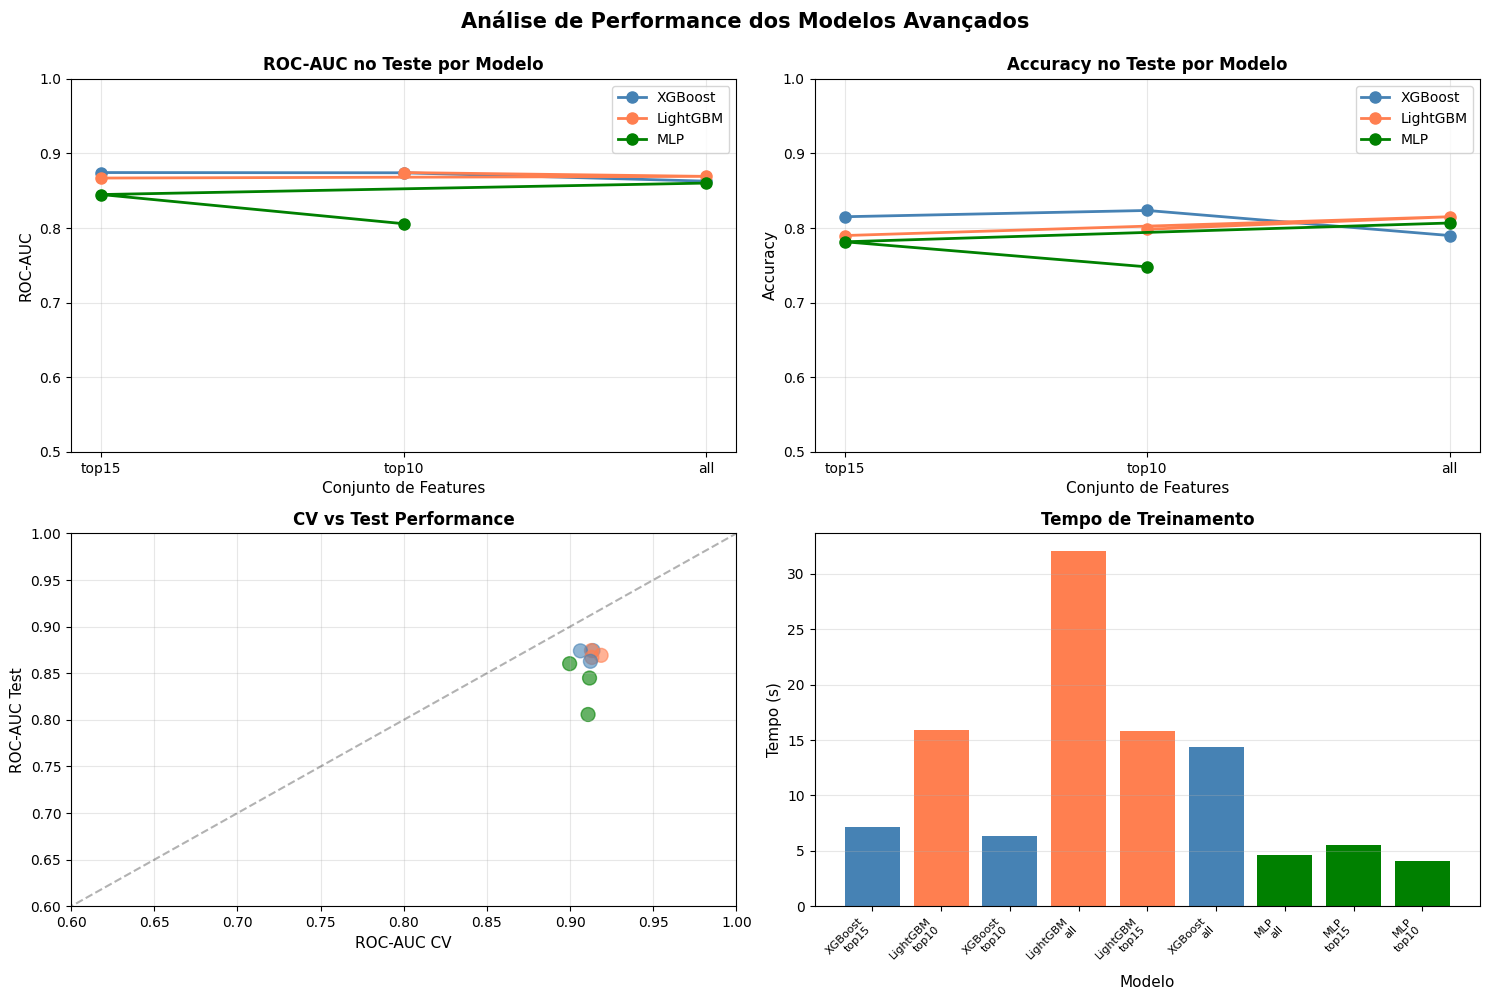

In [94]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

colors = {'XGBoost': 'steelblue', 'LightGBM': 'coral', 'MLP': 'green'}
for model_name in ['XGBoost', 'LightGBM', 'MLP']:
    data = results_df[results_df['Model'] == model_name]
    axes[0, 0].plot(data['Features'], data['Test_ROC_AUC'], 'o-', 
                     label=model_name, color=colors[model_name], linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Conjunto de Features', fontsize=11)
axes[0, 0].set_ylabel('ROC-AUC', fontsize=11)
axes[0, 0].set_title('ROC-AUC no Teste por Modelo', fontweight='bold', fontsize=12)
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)
axes[0, 0].set_ylim([0.5, 1.0])

for model_name in ['XGBoost', 'LightGBM', 'MLP']:
    data = results_df[results_df['Model'] == model_name]
    axes[0, 1].plot(data['Features'], data['Test_Accuracy'], 'o-', 
                     label=model_name, color=colors[model_name], linewidth=2, markersize=8)
axes[0, 1].set_xlabel('Conjunto de Features', fontsize=11)
axes[0, 1].set_ylabel('Accuracy', fontsize=11)
axes[0, 1].set_title('Accuracy no Teste por Modelo', fontweight='bold', fontsize=12)
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)
axes[0, 1].set_ylim([0.5, 1.0])

axes[1, 0].scatter(results_df['CV_ROC_AUC'], results_df['Test_ROC_AUC'], 
                    c=[colors[m] for m in results_df['Model']], s=100, alpha=0.6)
axes[1, 0].plot([0.5, 1.0], [0.5, 1.0], 'k--', alpha=0.3)
axes[1, 0].set_xlabel('ROC-AUC CV', fontsize=11)
axes[1, 0].set_ylabel('ROC-AUC Test', fontsize=11)
axes[1, 0].set_title('CV vs Test Performance', fontweight='bold', fontsize=12)
axes[1, 0].grid(alpha=0.3)
axes[1, 0].set_xlim([0.6, 1.0])
axes[1, 0].set_ylim([0.6, 1.0])

axes[1, 1].bar(range(len(results_df)), results_df['Training_Time'], 
                color=[colors[m] for m in results_df['Model']])
axes[1, 1].set_xlabel('Modelo', fontsize=11)
axes[1, 1].set_ylabel('Tempo (s)', fontsize=11)
axes[1, 1].set_title('Tempo de Treinamento', fontweight='bold', fontsize=12)
axes[1, 1].set_xticks(range(len(results_df)))
axes[1, 1].set_xticklabels([f"{row['Model']}\n{row['Features']}" 
                             for _, row in results_df.iterrows()], 
                            rotation=45, ha='right', fontsize=8)
axes[1, 1].grid(axis='y', alpha=0.3)

plt.suptitle('Análise de Performance dos Modelos Avançados', 
             fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

In [95]:
best_idx = results_df['Test_ROC_AUC'].idxmax()
best_model_name = results_df.loc[best_idx, 'Model']
best_features = results_df.loc[best_idx, 'Features']
best_model_key = f"{best_model_name}_{best_features}"

best_model_info = trained_models[best_model_key]
best_model = best_model_info['model']
best_feature_indices = best_model_info['feature_indices']

print(f"Melhor modelo: {best_model_name}")
print(f"Conjunto de features: {best_features}")
print(f"Número de features: {len(best_feature_indices)}")

X_test_best = X_test[:, best_feature_indices]
y_pred_proba_best = best_model.predict_proba(X_test_best)[:, 1]
y_pred_best = best_model.predict(X_test_best)

cm = confusion_matrix(y_test, y_pred_best)
tn, fp, fn, tp = cm.ravel()

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
npv = tn / (tn + fn) if (tn + fn) > 0 else 0
balanced_acc = (sensitivity + specificity) / 2

print(f"  ROC-AUC:           {roc_auc_score(y_test, y_pred_proba_best):.4f}")
print(f"  Accuracy:          {accuracy_score(y_test, y_pred_best):.4f}")
print(f"  Balanced Accuracy: {balanced_acc:.4f}")
print(f"  Sensitivity:       {sensitivity:.4f}")
print(f"  Specificity:       {specificity:.4f}")
print(f"  PPV (Precision):   {ppv:.4f}")
print(f"  NPV:               {npv:.4f}")
print(f"  F1-Score:          {f1_score(y_test, y_pred_best):.4f}")

Melhor modelo: XGBoost
Conjunto de features: top15
Número de features: 15
  ROC-AUC:           0.8744
  Accuracy:          0.8151
  Balanced Accuracy: 0.7902
  Sensitivity:       0.7179
  Specificity:       0.8625
  PPV (Precision):   0.7179
  NPV:               0.8625
  F1-Score:          0.7179


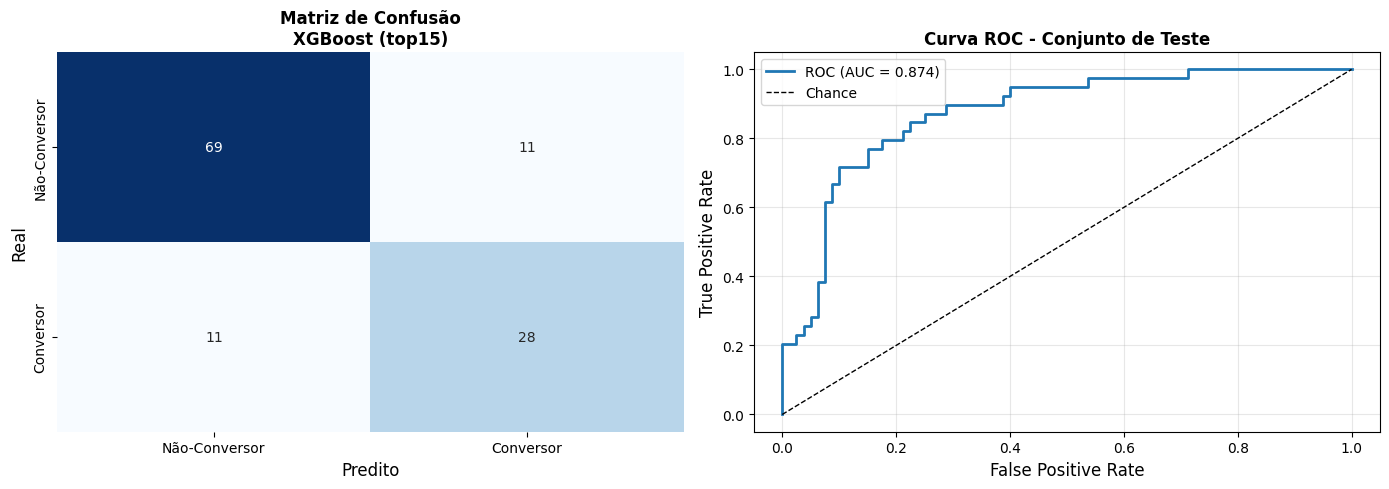

In [96]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Não-Conversor', 'Conversor'],
            yticklabels=['Não-Conversor', 'Conversor'],
            ax=axes[0], cbar=False)
axes[0].set_ylabel('Real', fontsize=12)
axes[0].set_xlabel('Predito', fontsize=12)
axes[0].set_title(f'Matriz de Confusão\n{best_model_name} ({best_features})', 
                   fontweight='bold', fontsize=12)

fpr, tpr, _ = roc_curve(y_test, y_pred_proba_best)
axes[1].plot(fpr, tpr, linewidth=2, 
             label=f'ROC (AUC = {roc_auc_score(y_test, y_pred_proba_best):.3f})')
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Chance')
axes[1].set_xlabel('False Positive Rate', fontsize=12)
axes[1].set_ylabel('True Positive Rate', fontsize=12)
axes[1].set_title('Curva ROC - Conjunto de Teste', fontweight='bold', fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


Vou ver quais features o modelo considera mais importantes

Feature Importance - XGBoost:
              Feature  Importance
                  faq    0.180483
               adas13    0.139551
      ravlt_immediate    0.088191
               adas11    0.059823
                  fdg    0.058766
                cdrsb    0.057455
ravlt_perc_forgetting    0.055300
                apoe4    0.050457
                 moca    0.048703
           entorhinal    0.048178
             fusiform    0.047708
       ravlt_learning    0.044753
          hippocampus    0.042965
                 mmse    0.042213
              midtemp    0.035456


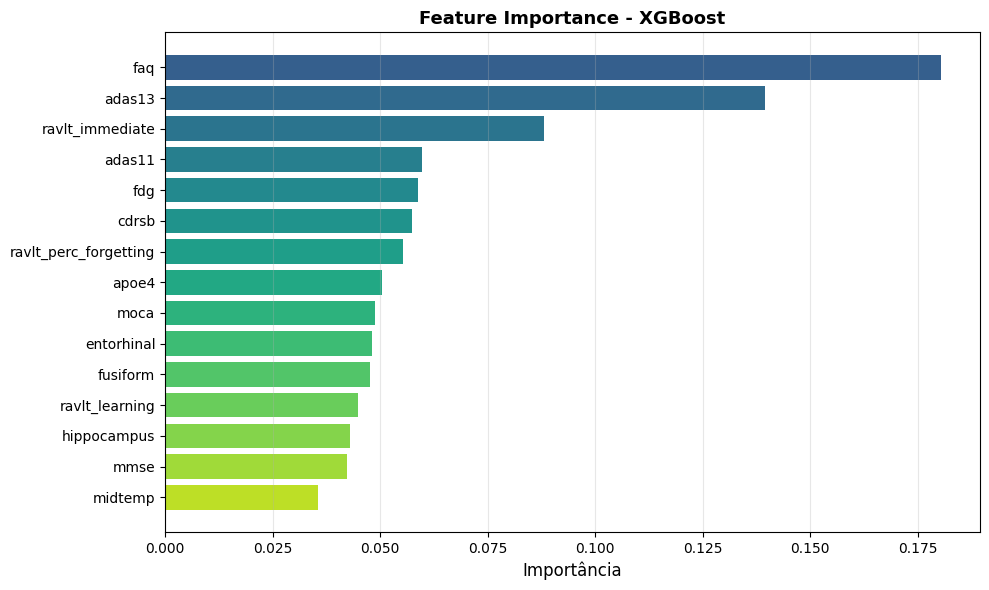

In [97]:
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    
    feature_importance_df = pd.DataFrame({
        'Feature': [feature_names[i] for i in best_feature_indices],
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    print(f"Feature Importance - {best_model_name}:")
    print(feature_importance_df.to_string(index=False))
    
    plt.figure(figsize=(10, 6))
    colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(feature_importance_df)))
    plt.barh(range(len(feature_importance_df)), feature_importance_df['Importance'], color=colors)
    plt.yticks(range(len(feature_importance_df)), feature_importance_df['Feature'])
    plt.xlabel('Importância', fontsize=12)
    plt.title(f'Feature Importance - {best_model_name}', fontweight='bold', fontsize=13)
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print(f"{best_model_name} não tem feature_importances_ nativo")

In [98]:
models_dir = "../models/"

try:
    baseline_results = pd.read_csv(f"{models_dir}final_results_with_ensemble.csv")
    
    print("COMPARAÇÃO: Modelos Avançados vs Baseline")
    print("\nBaseline 1 notebook:")
    baseline_top = baseline_results.nlargest(3, 'ROC-AUC_mean')
    print(baseline_top[['Model', 'ROC-AUC_mean', 'Accuracy_mean']].to_string(index=False))
    
    print("\nModelos Avançados deste notebook:")
    advanced_top = results_df.nlargest(3, 'Test_ROC_AUC')
    print(advanced_top[['Model', 'Features', 'Test_ROC_AUC', 'Test_Accuracy']].to_string(index=False))
    
    best_baseline_roc = baseline_results['ROC-AUC_mean'].max()
    best_advanced_roc = results_df['Test_ROC_AUC'].max()
    
    improvement = best_advanced_roc - best_baseline_roc
    
    print(f"\nMelhoria: {improvement:+.4f} ({improvement*100:+.2f}%)")
    
    if improvement > 0.01 or improvement > 0:
        print("\n Modelos avançados são MELHORES!")
    else:
        print("\n Modelos baseline são melhores neste caso")
        
except FileNotFoundError:
    print("Execute o notebook 03_baseline_models.ipynb primeiro.")

COMPARAÇÃO: Modelos Avançados vs Baseline

Baseline 1 notebook:
              Model  ROC-AUC_mean  Accuracy_mean
Logistic Regression      0.913490       0.819902
            SVM RBF      0.913346       0.805009
      Random Forest      0.911792       0.836879

Modelos Avançados deste notebook:
   Model Features  Test_ROC_AUC  Test_Accuracy
 XGBoost    top15      0.874359       0.815126
LightGBM    top10      0.874359       0.798319
 XGBoost    top10      0.874038       0.823529

Melhoria: -0.0391 (-3.91%)

 Modelos baseline são melhores neste caso


In [99]:
models_dir = "../models/"
os.makedirs(models_dir, exist_ok=True)

for model_key, model_info in trained_models.items():
    filename = f"advanced_{model_key.lower().replace(' ', '_')}.pkl"
    filepath = os.path.join(models_dir, filename)
    
    with open(filepath, 'wb') as f:
        pickle.dump(model_info, f)
    
    print(f" {model_key} salvo em: {filepath}")

results_df.to_csv(os.path.join(models_dir, 'advanced_models_results.csv'), index=False)
print(f"\n Resultados salvos em: {os.path.join(models_dir, 'advanced_models_results.csv')}")

 XGBoost_all salvo em: ../models/advanced_xgboost_all.pkl
 XGBoost_top15 salvo em: ../models/advanced_xgboost_top15.pkl
 XGBoost_top10 salvo em: ../models/advanced_xgboost_top10.pkl
 LightGBM_all salvo em: ../models/advanced_lightgbm_all.pkl
 LightGBM_top15 salvo em: ../models/advanced_lightgbm_top15.pkl
 LightGBM_top10 salvo em: ../models/advanced_lightgbm_top10.pkl
 MLP_all salvo em: ../models/advanced_mlp_all.pkl
 MLP_top15 salvo em: ../models/advanced_mlp_top15.pkl
 MLP_top10 salvo em: ../models/advanced_mlp_top10.pkl

 Resultados salvos em: ../models/advanced_models_results.csv


## 11. Ensemble combinando baseline + avançados

Agora vou juntar os melhores modelos baseline com os melhores modelos avançados pra ver se consigo melhorar ainda mais

In [ ]:

baseline_models_to_load = []

try:
    lr_path = os.path.join(models_dir, 'logistic_regression_optimized.pkl')
    if os.path.exists(lr_path):
        with open(lr_path, 'rb') as f:
            lr_model = pickle.load(f)
        if isinstance(lr_model, dict):
            baseline_models_to_load.append(('lr_baseline', lr_model['model']))
        else:
            baseline_models_to_load.append(('lr_baseline', lr_model))
        print(f"Logistic Regression carregada")
    
    rf_path = os.path.join(models_dir, 'random_forest_optimized.pkl')
    if os.path.exists(rf_path):
        with open(rf_path, 'rb') as f:
            rf_model = pickle.load(f)
        if isinstance(rf_model, dict):
            baseline_models_to_load.append(('rf_baseline', rf_model['model']))
        else:
            baseline_models_to_load.append(('rf_baseline', rf_model))
        print(f"Random Forest baseline carregada")
    
    svm_path = os.path.join(models_dir, 'svm_rbf_optimized.pkl')
    if os.path.exists(svm_path):
        with open(svm_path, 'rb') as f:
            svm_model = pickle.load(f)
        if isinstance(svm_model, dict):
            baseline_models_to_load.append(('svm_baseline', svm_model['model']))
        else:
            baseline_models_to_load.append(('svm_baseline', svm_model))
        print(f"SVM RBF baseline carregado")
        
except Exception as e:
    print(f"Erro ao carregar modelos baseline: {e}")

advanced_models_to_use = []

if 'trained_models' in globals() and len(trained_models) > 0:
    top_3_advanced = results_df.nlargest(3, 'Test_ROC_AUC')
    
    for idx, row in top_3_advanced.iterrows():
        model_key = f"{row['Model']} - {row['Features']}"
        if model_key in trained_models:
            model_info = trained_models[model_key]
            model_name = f"{row['Model']}_{row['Features']}".lower().replace(' ', '_')
            advanced_models_to_use.append((model_name, model_info['model']))
            print(f"{model_key} selecionado (ROC-AUC: {row['Test_ROC_AUC']:.4f})")
else:
    try:
        xgb_files = ['advanced_xgboost_top15.pkl', 'advanced_xgboost_top10.pkl', 'advanced_xgboost_all.pkl']
        for fname in xgb_files:
            fpath = os.path.join(models_dir, fname)
            if os.path.exists(fpath):
                with open(fpath, 'rb') as f:
                    xgb_model = pickle.load(f)
                if isinstance(xgb_model, dict):
                    advanced_models_to_use.append(('xgb_advanced', xgb_model['model']))
                    print(f"XGBoost carregado de {fname}")
                break
        
        lgb_files = ['advanced_lightgbm_top15.pkl', 'advanced_lightgbm_top10.pkl', 'advanced_lightgbm_all.pkl']
        for fname in lgb_files:
            fpath = os.path.join(models_dir, fname)
            if os.path.exists(fpath):
                with open(fpath, 'rb') as f:
                    lgb_model = pickle.load(f)
                if isinstance(lgb_model, dict):
                    advanced_models_to_use.append(('lgb_advanced', lgb_model['model']))
                    print(f"LightGBM carregado de {fname}")
                break
                
    except Exception as e:
        print(f"Erro ao carregar modelos avançados: {e}")

print(f"\nTotal de modelos no ensemble: {len(baseline_models_to_load) + len(advanced_models_to_use)}")

 Logistic Regression carregada
 Random Forest baseline carregada
 SVM RBF baseline carregado

 Total de modelos no ensemble: 3


In [ ]:
all_models = baseline_models_to_load + advanced_models_to_use

if len(all_models) > 0:
    ensemble = VotingClassifier(
        estimators=all_models,
        voting='soft',
        n_jobs=-1
    )
    
    ensemble.fit(X_train[:, best_feature_indices], y_train)
    
    y_pred_ensemble = ensemble.predict(X_test[:, best_feature_indices])
    y_pred_proba_ensemble = ensemble.predict_proba(X_test[:, best_feature_indices])[:, 1]
    
    ensemble_roc_auc = roc_auc_score(y_test, y_pred_proba_ensemble)
    ensemble_accuracy = accuracy_score(y_test, y_pred_ensemble)
    ensemble_f1 = f1_score(y_test, y_pred_ensemble)
    
    print(f"ROC-AUC: {ensemble_roc_auc:.4f}")
    print(f"Accuracy: {ensemble_accuracy:.4f}")
    print(f"F1-Score: {ensemble_f1:.4f}")
    
    print(f"\nComparação:")
    print(f"Melhor modelo individual: {best_model_name} ({best_features})")
    print(f"  ROC-AUC: {results_df.loc[best_idx, 'Test_ROC_AUC']:.4f}")
    print(f"Ensemble:")
    print(f"  ROC-AUC: {ensemble_roc_auc:.4f}")
    
    diff = ensemble_roc_auc - results_df.loc[best_idx, 'Test_ROC_AUC']
    if diff > 0:
        print(f"\nEnsemble melhorou em {diff:.4f} ({diff*100:.2f}%)")
    else:
        print(f"\nEnsemble não melhorou (diferença: {diff:.4f})")
else:
    print("Não foi possível criar o ensemble - modelos não encontrados")

ROC-AUC: 0.8702
Accuracy: 0.8067
F1-Score: 0.7013

 Comparação:
Melhor modelo individual: XGBoost (top15)
  ROC-AUC: 0.8744
Ensemble:
  ROC-AUC: 0.8702

 Ensemble não melhorou (diferença: -0.0042)


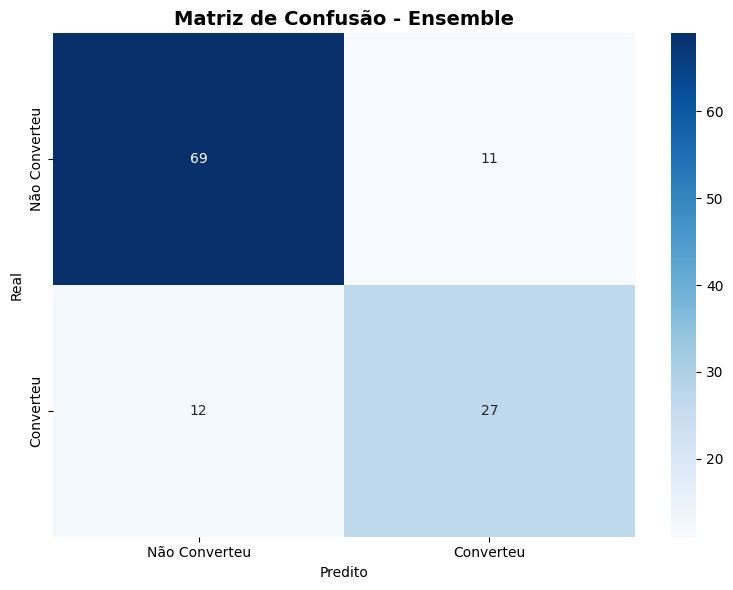


Métricas Detalhadas do Ensemble:
Sensitivity (Recall): 0.6923
Specificity: 0.8625
PPV (Precision): 0.7105
NPV: 0.8519
Balanced Accuracy: 0.7774


In [102]:
if len(all_models) > 0:
    cm_ensemble = confusion_matrix(y_test, y_pred_ensemble)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_ensemble, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Não Converteu', 'Converteu'],
                yticklabels=['Não Converteu', 'Converteu'])
    plt.title('Matriz de Confusão - Ensemble', fontsize=14, fontweight='bold')
    plt.ylabel('Real')
    plt.xlabel('Predito')
    plt.tight_layout()
    plt.show()
    
    tn, fp, fn, tp = cm_ensemble.ravel()
    
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    ppv = tp / (tp + fp)
    npv = tn / (tn + fn)
    balanced_acc = (sensitivity + specificity) / 2
    
    print("\nMétricas Detalhadas do Ensemble:")
    print(f"Sensitivity (Recall): {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"PPV (Precision): {ppv:.4f}")
    print(f"NPV: {npv:.4f}")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")


Agora vou ver onde os modelos erraram, quais pacientes foram difíceis de classificar

In [ ]:
errors_df = pd.DataFrame({
    'True_Label': y_test,
    'Predicted_Label': y_pred_best,
    'Predicted_Proba': y_pred_proba_best,
    'Correct': y_test == y_pred_best
})

def classify_prediction(row):
    if row['True_Label'] == 1 and row['Predicted_Label'] == 1:
        return 'True Positive (TP)'
    elif row['True_Label'] == 0 and row['Predicted_Label'] == 0:
        return 'True Negative (TN)'
    elif row['True_Label'] == 0 and row['Predicted_Label'] == 1:
        return 'False Positive (FP)'
        return 'False Negative (FN)'

errors_df['Prediction_Type'] = errors_df.apply(classify_prediction, axis=1)

print("ANÁLISE DE ERROS DO MELHOR MODELO")
print(f"Modelo: {best_model_name} com {best_features}")
print(f"\nTotal de predições: {len(errors_df)}")
print(f"Acertos: {errors_df['Correct'].sum()} ({errors_df['Correct'].sum()/len(errors_df)*100:.1f}%)")
print(f"Erros: {(~errors_df['Correct']).sum()} ({(~errors_df['Correct']).sum()/len(errors_df)*100:.1f}%)")

print("\nDistribuição dos erros:")
print(errors_df['Prediction_Type'].value_counts())

fp_cases = errors_df[errors_df['Prediction_Type'] == 'False Positive (FP)']
fn_cases = errors_df[errors_df['Prediction_Type'] == 'False Negative (FN)']

print(f"\nFalsos Positivos (FP): {len(fp_cases)}")
print(f"   Pacientes que NÃO converteram mas o modelo disse que SIM")
print(f"   Probabilidade média: {fp_cases['Predicted_Proba'].mean():.3f}")
print(f"   Probabilidade min: {fp_cases['Predicted_Proba'].min():.3f}")
print(f"   Probabilidade max: {fp_cases['Predicted_Proba'].max():.3f}")

print(f"\nFalsos Negativos (FN): {len(fn_cases)}")
print(f"   Pacientes que CONVERTERAM mas o modelo disse que NÃO")
print(f"   Probabilidade média: {fn_cases['Predicted_Proba'].mean():.3f}")
print(f"   Probabilidade min: {fn_cases['Predicted_Proba'].min():.3f}")
print(f"   Probabilidade max: {fn_cases['Predicted_Proba'].max():.3f}")

ANÁLISE DE ERROS DO MELHOR MODELO
Modelo: XGBoost com top15

Total de predições: 119
Acertos: 97 (81.5%)
Erros: 22 (18.5%)

Distribuição dos erros:
Prediction_Type
True Negative (TN)     69
True Positive (TP)     28
False Positive (FP)    11
Name: count, dtype: int64

 Falsos Positivos (FP): 11
   Pacientes que NÃO converteram mas o modelo disse que SIM
   Probabilidade média: 0.709
   Probabilidade min: 0.512
   Probabilidade max: 0.909

 Falsos Negativos (FN): 0
   Pacientes que CONVERTERAM mas o modelo disse que NÃO
   Probabilidade média: nan
   Probabilidade min: nan
   Probabilidade max: nan


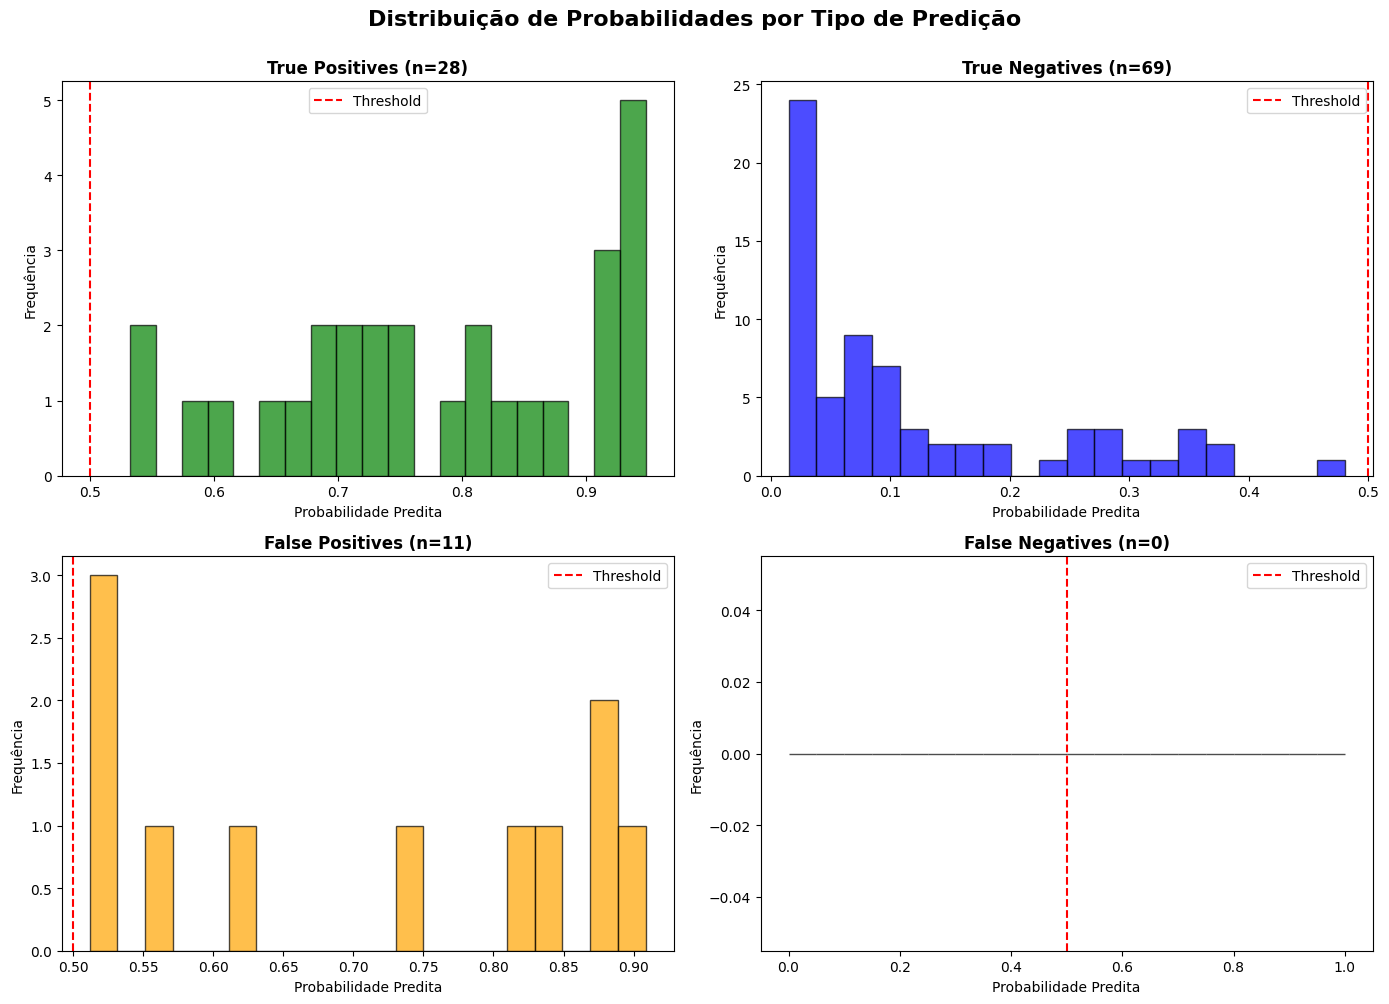

In [104]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

tp_cases = errors_df[errors_df['Prediction_Type'] == 'True Positive (TP)']
axes[0, 0].hist(tp_cases['Predicted_Proba'], bins=20, color='green', alpha=0.7, edgecolor='black')
axes[0, 0].set_title(f'True Positives (n={len(tp_cases)})', fontweight='bold')
axes[0, 0].set_xlabel('Probabilidade Predita')
axes[0, 0].set_ylabel('Frequência')
axes[0, 0].axvline(0.5, color='red', linestyle='--', label='Threshold')
axes[0, 0].legend()

tn_cases = errors_df[errors_df['Prediction_Type'] == 'True Negative (TN)']
axes[0, 1].hist(tn_cases['Predicted_Proba'], bins=20, color='blue', alpha=0.7, edgecolor='black')
axes[0, 1].set_title(f'True Negatives (n={len(tn_cases)})', fontweight='bold')
axes[0, 1].set_xlabel('Probabilidade Predita')
axes[0, 1].set_ylabel('Frequência')
axes[0, 1].axvline(0.5, color='red', linestyle='--', label='Threshold')
axes[0, 1].legend()

axes[1, 0].hist(fp_cases['Predicted_Proba'], bins=20, color='orange', alpha=0.7, edgecolor='black')
axes[1, 0].set_title(f'False Positives (n={len(fp_cases)})', fontweight='bold')
axes[1, 0].set_xlabel('Probabilidade Predita')
axes[1, 0].set_ylabel('Frequência')
axes[1, 0].axvline(0.5, color='red', linestyle='--', label='Threshold')
axes[1, 0].legend()

axes[1, 1].hist(fn_cases['Predicted_Proba'], bins=20, color='red', alpha=0.7, edgecolor='black')
axes[1, 1].set_title(f'False Negatives (n={len(fn_cases)})', fontweight='bold')
axes[1, 1].set_xlabel('Probabilidade Predita')
axes[1, 1].set_ylabel('Frequência')
axes[1, 1].axvline(0.5, color='red', linestyle='--', label='Threshold')
axes[1, 1].legend()

plt.suptitle('Distribuição de Probabilidades por Tipo de Predição', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

In [ ]:
uncertainty_threshold = 0.1  

uncertain_cases = errors_df[
    (errors_df['Predicted_Proba'] >= 0.5 - uncertainty_threshold) &
    (errors_df['Predicted_Proba'] <= 0.5 + uncertainty_threshold)
]

print(f"Total de casos incertos: {len(uncertain_cases)} ({len(uncertain_cases)/len(errors_df)*100:.1f}%)")
print(f"\nDistribuição:")
print(uncertain_cases['Prediction_Type'].value_counts())

print(f"\nAcurácia nos casos incertos: {uncertain_cases['Correct'].sum()/len(uncertain_cases)*100:.1f}%")
print(f"Acurácia nos casos certos (proba > 0.6 ou < 0.4): {errors_df[~errors_df.index.isin(uncertain_cases.index)]['Correct'].sum()/len(errors_df[~errors_df.index.isin(uncertain_cases.index)])*100:.1f}%")

print("\nInsight:")
if uncertain_cases['Correct'].sum()/len(uncertain_cases) < errors_df['Correct'].sum()/len(errors_df):
    print("O modelo tem mais dificuldade nos casos incertos (como esperado)")
else:
    print("O modelo mantém boa performance mesmo em casos incertos")

Total de casos incertos: 10 (8.4%)

Distribuição:
Prediction_Type
False Positive (FP)    4
True Positive (TP)     3
True Negative (TN)     1
Name: count, dtype: int64

Acurácia nos casos incertos: 40.0%
Acurácia nos casos certos (proba > 0.6 ou < 0.4): 85.3%

 Insight:
O modelo tem mais dificuldade nos casos incertos (como esperado)


In [ ]:
if len(all_models) > 0:
    
    errors_ensemble_df = pd.DataFrame({
        'True_Label': y_test,
        'Predicted_Label': y_pred_ensemble,
        'Predicted_Proba': y_pred_proba_ensemble,
        'Correct': y_test == y_pred_ensemble
    })
    
    errors_ensemble_df['Prediction_Type'] = errors_ensemble_df.apply(classify_prediction, axis=1)
    
    print(f"\nMelhor Modelo Individual:")
    print(f"  Erros: {(~errors_df['Correct']).sum()}")
    print(f"  FP: {len(fp_cases)}, FN: {len(fn_cases)}")
    
    fp_ensemble = errors_ensemble_df[errors_ensemble_df['Prediction_Type'] == 'False Positive (FP)']
    fn_ensemble = errors_ensemble_df[errors_ensemble_df['Prediction_Type'] == 'False Negative (FN)']
    
    print(f"\nEnsemble:")
    print(f"  Erros: {(~errors_ensemble_df['Correct']).sum()}")
    print(f"  FP: {len(fp_ensemble)}, FN: {len(fn_ensemble)}")
    
    corrected_by_ensemble = (~errors_df['Correct']) & (errors_ensemble_df['Correct'])
    new_errors_by_ensemble = (errors_df['Correct']) & (~errors_ensemble_df['Correct'])
    
    print(f"\nCasos corrigidos pelo ensemble: {corrected_by_ensemble.sum()}")
    print(f"Novos erros do ensemble: {new_errors_by_ensemble.sum()}")
    
    net_improvement = corrected_by_ensemble.sum() - new_errors_by_ensemble.sum()
    if net_improvement > 0:
        print(f"\nMelhoria líquida: +{net_improvement} predições corretas")
    elif net_improvement < 0:
        print(f"\nPiora líquida: {net_improvement} predições corretas")
    else:
        print(f"\nSem mudança líquida no número de erros")


Melhor Modelo Individual:
  Erros: 22
  FP: 11, FN: 0

Ensemble:
  Erros: 23
  FP: 11, FN: 0

 Casos corrigidos pelo ensemble: 2
 Novos erros do ensemble: 3

 Piora líquida: -1 predições corretas


## 13. Salvando modelos e resultados finais

In [ ]:
if len(all_models) > 0:
    ensemble_path = os.path.join(models_dir, 'ensemble_baseline_advanced.pkl')
    with open(ensemble_path, 'wb') as f:
        pickle.dump({
            'model': ensemble,
            'feature_indices': best_feature_indices,
            'test_roc_auc': ensemble_roc_auc,
            'test_accuracy': ensemble_accuracy,
            'test_f1': ensemble_f1,
            'num_models': len(all_models),
            'models_used': [name for name, _ in all_models]
        }, f)
    print(f"Ensemble salvo em: {ensemble_path}")

errors_path = os.path.join(models_dir, 'error_analysis.csv')
errors_df.to_csv(errors_path, index=False)
print(f"Análise de erros salva em: {errors_path}")

if len(all_models) > 0:
    errors_ensemble_path = os.path.join(models_dir, 'error_analysis_ensemble.csv')
    errors_ensemble_df.to_csv(errors_ensemble_path, index=False)
    print(f"Análise de erros do ensemble salva em: {errors_ensemble_path}")

 Ensemble salvo em: ../models/ensemble_baseline_advanced.pkl
 Análise de erros salva em: ../models/error_analysis.csv
 Análise de erros do ensemble salva em: ../models/error_analysis_ensemble.csv


In [ ]:


print(f"\nMelhor modelo individual: {best_model_name} com {best_features}")
print(f"   ROC-AUC Test: {results_df.loc[best_idx, 'Test_ROC_AUC']:.4f}")
print(f"   Acurácia Test: {results_df.loc[best_idx, 'Test_Accuracy']:.4f}")
print(f"   F1-Score Test: {results_df.loc[best_idx, 'Test_F1']:.4f}")

if len(all_models) > 0:
    print(f"\nEnsemble ({len(all_models)} modelos):")
    print(f"   ROC-AUC Test: {ensemble_roc_auc:.4f}")
    print(f"   Acurácia Test: {ensemble_accuracy:.4f}")
    print(f"   F1-Score Test: {ensemble_f1:.4f}")
    
    if ensemble_roc_auc > results_df.loc[best_idx, 'Test_ROC_AUC']:
        print(f"\n   Ensemble é o melhor! (+{(ensemble_roc_auc - results_df.loc[best_idx, 'Test_ROC_AUC']):.4f})")
    else:
        print(f"\n   Modelo individual ainda é melhor")

print(f"\nTotal de configurações testadas: {len(results_df)}")
print(f"Tempo total de treinamento: {results_df['Training_Time'].sum():.1f}s ({results_df['Training_Time'].sum()/60:.1f} min)")

print(f"\nErros do melhor modelo:")
print(f"   Total de erros: {(~errors_df['Correct']).sum()} / {len(errors_df)}")
print(f"   Falsos Positivos: {len(fp_cases)}")
print(f"   Falsos Negativos: {len(fn_cases)}")
print(f"   Casos incertos (0.4-0.6): {len(uncertain_cases)}")

print(f"\nTudo salvo em: {models_dir}")



RESUMO FINAL - MODELOS AVANÇADOS

🏆 Melhor modelo individual: XGBoost com top15
   ROC-AUC Test: 0.8744
   Acurácia Test: 0.8151
   F1-Score Test: 0.7179

🎯 Ensemble (3 modelos):
   ROC-AUC Test: 0.8702
   Acurácia Test: 0.8067
   F1-Score Test: 0.7013

   ⚠️ Modelo individual ainda é melhor

Total de configurações testadas: 9
Tempo total de treinamento: 105.8s (1.8 min)

📊 Erros do melhor modelo:
   Total de erros: 22 / 119
   Falsos Positivos: 11
   Falsos Negativos: 0
   Casos incertos (0.4-0.6): 10

💾 Tudo salvo em: ../models/
